<a href="https://colab.research.google.com/github/adamwojt/dalle-mini/blob/main/tools/inference/inference_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DALL·E mini - Inference pipeline

*Generate images from a text prompt*

<img src="https://github.com/borisdayma/dalle-mini/blob/main/img/logo.png?raw=true" width="200">

This notebook illustrates [DALL·E mini](https://github.com/borisdayma/dalle-mini) inference pipeline.

Just want to play? Use directly [DALL·E mini app](https://huggingface.co/spaces/dalle-mini/dalle-mini).

For more understanding of the model, refer to [the report](https://wandb.ai/dalle-mini/dalle-mini/reports/DALL-E-mini--Vmlldzo4NjIxODA).

## 🛠️ Installation and set-up

In [1]:
# Install required libraries
!pip install -q dalle-mini
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git

     |████████████████████████████████| 197 kB 7.9 MB/s 
     |████████████████████████████████| 4.2 MB 60.2 MB/s 
     |████████████████████████████████| 235 kB 51.9 MB/s 
     |████████████████████████████████| 53 kB 1.3 MB/s 
     |████████████████████████████████| 175 kB 72.3 MB/s 
     |████████████████████████████████| 1.8 MB 31.5 MB/s 
     |████████████████████████████████| 216 kB 58.1 MB/s 
     |████████████████████████████████| 140 kB 6.2 MB/s 
     |████████████████████████████████| 51 kB 4.5 MB/s 
     |████████████████████████████████| 72 kB 562 kB/s 
     |████████████████████████████████| 596 kB 49.2 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
     |████████████████████████████████| 6.6 MB 11.2 MB/s 
     |████████████████████████████████| 145 kB 50.5 MB/s 
     |████████████████████████████████| 181 kB 68.2 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 


We load required models:
* DALL·E mini for text to encoded images
* VQGAN for decoding images
* CLIP for scoring predictions

In [2]:
# Model references

# dalle-mega
DALLE_MODEL = "dalle-mini/dalle-mini/mega-1-fp16:latest"  # can be wandb artifact or 🤗 Hub or local folder or google bucket
DALLE_COMMIT_ID = None

# if the notebook crashes too often you can use dalle-mini instead by uncommenting below line
DALLE_MODEL = "dalle-mini/dalle-mini/mini-1:v0"

# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

In [3]:
import jax
import jax.numpy as jnp

# check how many devices are available
jax.local_device_count()

1

In [4]:
# Load models & tokenizer
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

# Load dalle-mini
model, params = DalleBart.from_pretrained(
    DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False
)

# Load VQGAN
vqgan, vqgan_params = VQModel.from_pretrained(
    VQGAN_REPO, revision=VQGAN_COMMIT_ID, _do_init=False
)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Downloading large artifact mini-1:v0, 1673.43MB. 7 files... Done. 0:0:15.7


Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/290M [00:00<?, ?B/s]

Model parameters are replicated on each device for faster inference.

In [5]:
from flax.jax_utils import replicate

params = replicate(params)
vqgan_params = replicate(vqgan_params)

Model functions are compiled and parallelized to take advantage of multiple devices.

In [6]:
from functools import partial

# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

Keys are passed to the model on each device to generate unique inference per device.

In [7]:
import random

# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

## 🖍 Text Prompt

Our model requires processing prompts.

In [8]:
from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

wandb: Downloading large artifact mini-1:v0, 1673.43MB. 7 files... Done. 0:0:11.8


Downloading:   0%|          | 0.00/34.2M [00:00<?, ?B/s]

Let's define some text prompts.

In [94]:
prompts = ["Angry pregnant lithuanian woman"]
tokenized_prompts = processor(prompts)
tokenized_prompt = replicate(tokenized_prompts)

## 🎨 Generate images

We generate images using dalle-mini model and decode them with the VQGAN.

Prompts: ['Angry pregnant lithuanian woman']



  0%|          | 0/8 [00:00<?, ?it/s]

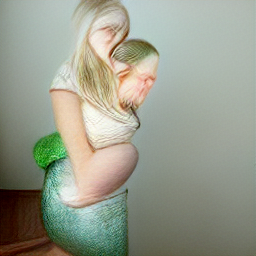

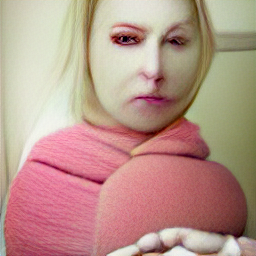

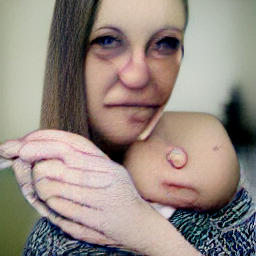

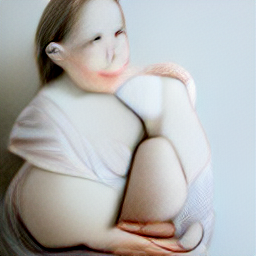

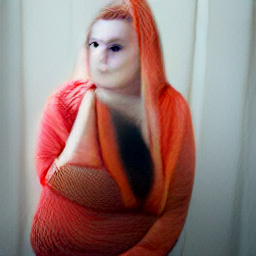

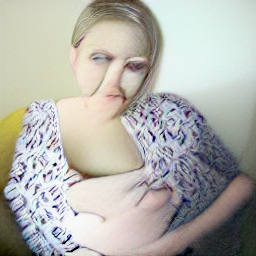

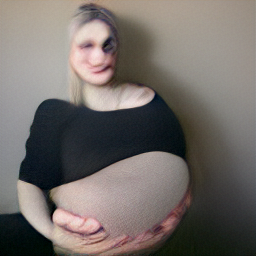

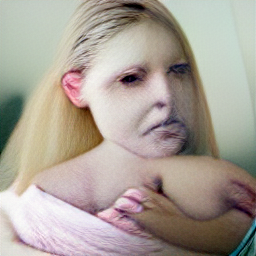

In [95]:
# number of predictions per prompt
n_predictions = 8

# We can customize generation parameters (see https://huggingface.co/blog/how-to-generate)
gen_top_k = None
gen_top_p = None
temperature = None
cond_scale = 10.0

from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange

print(f"Prompts: {prompts}\n")
# generate images
images = []
for i in trange(max(n_predictions // jax.device_count(), 1)):
    # get a new key
    key, subkey = jax.random.split(key)
    # generate images
    encoded_images = p_generate(
        tokenized_prompt,
        shard_prng_key(subkey),
        params,
        gen_top_k,
        gen_top_p,
        temperature,
        cond_scale,
    )
    # remove BOS
    encoded_images = encoded_images.sequences[..., 1:]
    # decode images
    decoded_images = p_decode(encoded_images, vqgan_params)
    decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
    for decoded_img in decoded_images:
        img = Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
        images.append(img)
        display(img)
        print()